## Projeto Final - Machine Learning

#### Tema: Analysis of Bike Sharing Rental System

Grupo: Pedro Perri, Renato Tajima e Victor Habib

### Introdução

Para o projeto final de Machine Learning foi utilizado o dado "Bike Sharing Systems" da UCI (University California Irvine) Machine Learning Repository. Os anos de análise foram 2011 e 2012, a cidade de observação é Washington, DC.

### Objetivo do Projeto

Prever quantas bicicletas são alugadas em um dia, baseado em variáveis independentes que maiores influências. A partir desse questionamento, foi feito um estudo aprofundado de análise exploratória de dados que nos ajudaram a identificar padrões para formular conclusões. Em seguida, foram realizados modelos de regressões para a previsão desse aluguel baseado nas condições identificadas.

##### Variables:

* instant: record index
* dteday: date
* season: season (1: Winter, 2: Spring, 3: Summer, 4: Fall)
* yr: year (0: 2011, 1: 2012)
* mnth : month ( 1 to 12)
* hr: hour (0 to 23)
* holiday: weather day is holiday or not
* weekday: day of the week
* workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
* weathersit : 
    * 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    * 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    * 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    * 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
* temp: Normalized temperature in Celsius. The values are divided to 41 (max)
* atemp: Normalized feeling temperature in Celsius. The values are divided to 50 (max)
* hum: Normalized humidity. The values are divided to 100 (max)
* windspeed: Normalized wind speed. The values are divided to 67 (max)
* casual: count of casual users
* registered: count of registered users
* cnt: count of total rental bikes including both casual and registered

## Análise Exploratória

**Inicialização:**
Importar bibliotecas, e ler e organizar os dados em DataFrames que serão utilizados durante o estudo.

In [1]:
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from siuba import *
from plotnine import *
from scipy.stats import iqr
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
from sklearn.metrics import mean_squared_error, confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

%matplotlib inline

In [2]:
RANDOM_SEED = 43
np.random.seed(RANDOM_SEED)

In [3]:
df_day = pd.read_csv("day.csv")
df_hour = pd.read_csv("hour.csv")

In [4]:
(df_day>>
     select(-_.instant)>>
     head())

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [5]:
df_day.describe()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000
mean,366.000000,2.496580,0.500684,6.519836,0.028728,2.997264,0.683995,1.395349,0.495385,0.474354,0.627894,0.190486,848.176471,3656.172367,4504.348837
std,211.165812,1.110807,0.500342,3.451913,0.167155,2.004787,0.465233,0.544894,0.183051,0.162961,0.142429,0.077498,686.622488,1560.256377,1937.211452
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.059130,0.079070,0.000000,0.022392,2.000000,20.000000,22.000000
25%,183.500000,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,0.337083,0.337842,0.520000,0.134950,315.500000,2497.000000,3152.000000
50%,366.000000,3.000000,1.000000,7.000000,0.000000,3.000000,1.000000,1.000000,0.498333,0.486733,0.626667,0.180975,713.000000,3662.000000,4548.000000
75%,548.500000,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,0.655417,0.608602,0.730209,0.233214,1096.000000,4776.500000,5956.000000
max,731.000000,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,0.861667,0.840896,0.972500,0.507463,3410.000000,6946.000000,8714.000000


**Organizando os dados para tornar o DataFrame mais legível:**

In [6]:
df_day['weathersit'] = df_day['weathersit'].replace([1,2,3,4],["Good", "Moderate", "Bad", "Very Bad"])
df_day['weekday'] = df_day['weekday'].replace([0,1,2,3,4,5,6],["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"])
df_day['season'] = df_day['season'].replace([1,2,3,4],["Winter", "Spring", "Summer", "Fall"])
df_day['workingday'] = df_day['workingday'].replace([0,1],["No","Yes"])
df_day['holiday'] = df_day['holiday'].replace([0,1],["No", "Yes"])
df_day['yr'] = df_day['yr'].replace([0,1],[2011, 2012])
df_day['mnth'] = df_day['mnth'].replace([1,2,3,4,5,6,7,8,9,10,11,12],["Jan", "Feb", "Mar", "Apr", "Mai", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])

**Transformando o DataFrame no formato Tidy:**

In [7]:
df_day_tidy = (df_day >>
     gather("user", "rents", "casual", "registered"))

df_day_tidy.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,user,rents
0,1,2011-01-01,Winter,2011,Jan,No,Saturday,No,Moderate,0.344167,0.363625,0.805833,0.160446,985,casual,331
1,2,2011-01-02,Winter,2011,Jan,No,Sunday,No,Moderate,0.363478,0.353739,0.696087,0.248539,801,casual,131
2,3,2011-01-03,Winter,2011,Jan,No,Monday,Yes,Good,0.196364,0.189405,0.437273,0.248309,1349,casual,120
3,4,2011-01-04,Winter,2011,Jan,No,Tuesday,Yes,Good,0.200000,0.212122,0.590435,0.160296,1562,casual,108
4,5,2011-01-05,Winter,2011,Jan,No,Wednesday,Yes,Good,0.226957,0.229270,0.436957,0.186900,1600,casual,82


**Primeiro entendendo individualmente as variáveis:**

Obs: Para o entendimento das variáveis, baseou-se no dado sem estar organizado no formato Tidy, para evitar repetições de valores.

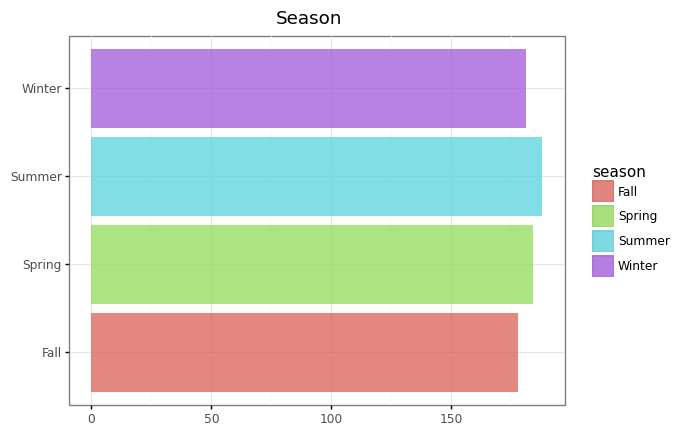

<ggplot: (-9223371881000746664)>

In [8]:
(df_day >>
     ggplot(aes("season", fill = "season"))+
        geom_bar(alpha = 0.75)+
        labs(x = "", y = "", title = "Season")+
        theme(legend_position = "none")+
        coord_flip()+
        theme_bw())

A partir do gráfico acima, nota-se que a quantidade de dados varia conforme a estação ano. Assim, ao realizar uma análise que justificasse essa característica, observou-se que as estações do ano apresentam quantidade de dias diferentes, como listado abaixo:

In [9]:
(df_day>>
    filter(_.yr == 2011)>>
    group_by(_.season)>>
    summarize(count = _.season.count()))

,season,count
0,Fall,89
1,Spring,92
2,Summer,94
3,Winter,90


In [10]:
(df_day>>
    filter(_.yr == 2012)>>
    group_by(_.season)>>
    summarize(count = _.season.count()))

,season,count
0,Fall,89
1,Spring,92
2,Summer,94
3,Winter,91


Observando as tabelas que representam as quantidadades de dias em cada estação do ano em 2011 e 2012, respectivamente, percebe-se que em 2012 há um dia a mais no inverno, totalizando 366 dias, explicado por ser um ano bissexto.

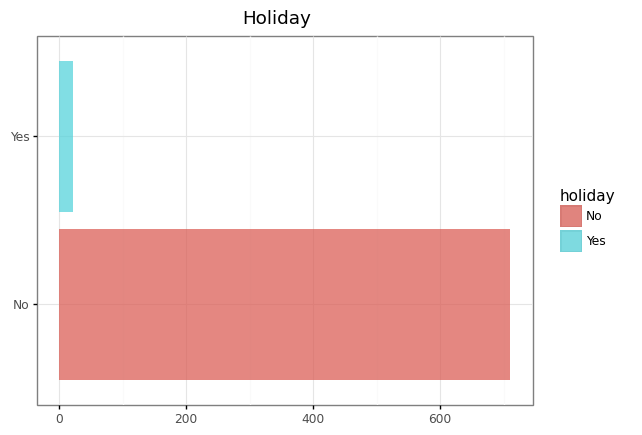

<ggplot: (155854170274)>

In [11]:
(df_day >>
     ggplot(aes("holiday", fill = "holiday"))+
        geom_bar(alpha = 0.75)+
        labs(x = "", y = "", title = "Holiday")+
        theme(legend_position = "none")+
        coord_flip()+
        theme_bw())

Observando o gráfico acima, pode-se concluir que em nossa amostra o número de dados referentes a feriados é muito menor do que referentes a dias normais. Isso é de se esperar, já que durante o ano, há poucos feriados no calendário. Entretanto, baseando-se nesse cenário, o grupo propôs mais adiante uma análise referente aos aluguéis de bicicletas em dias normais e em feriados, visando entender se essas datas especiais influenciam na quantidade de aluguéis realizados.

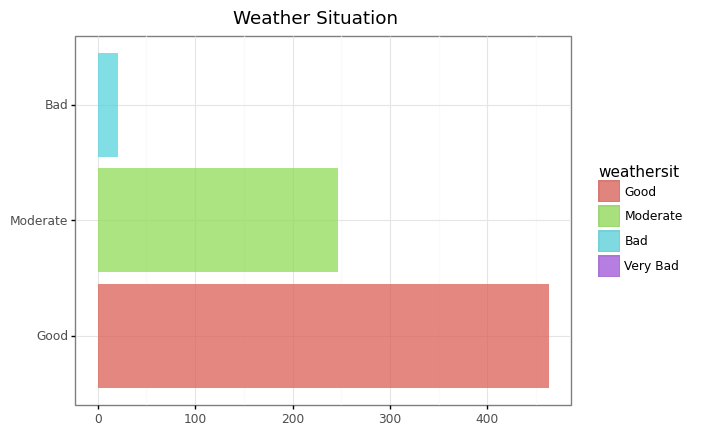

<ggplot: (-9223371881012797324)>

In [12]:
(df_day >>
     mutate(weathersit = pd.Categorical(df_day["weathersit"], categories =  ["Good", "Moderate", "Bad", "Very Bad"])) >>   
     ggplot(aes("weathersit", fill = "weathersit"))+
        geom_bar(alpha = 0.75)+
        labs(x = "", y = "", title = "Weather Situation")+
        theme(legend_position = "none")+
        coord_flip()+
        theme_bw())

Como mostrado no gráfico acima, durante os anos de 2011 e 2012, período referente a nossa amostra de dados, as condições climáticas foram majoritariamente boas. Mais adiante, o grupo se aprofundou nesse tema para verificar a influência do clima na quantidade de aluguéis realizados.

Além disso, no intuito de comparar as condições climáticas dos dois anos em questão, plotou-se o gráfico abaixo:

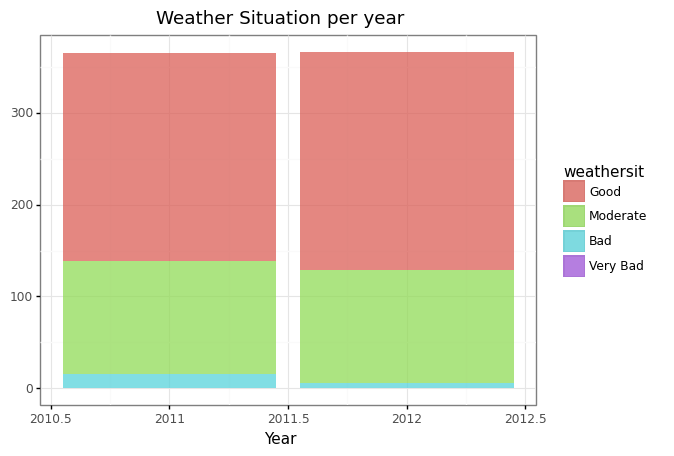

<ggplot: (155854164656)>

In [13]:
(df_day >>
     mutate(weathersit = pd.Categorical(df_day["weathersit"], categories =  ["Good", "Moderate", "Bad", "Very Bad"])) >>   
     ggplot(aes("yr", fill = "weathersit"))+
        geom_bar(alpha = 0.75)+
        labs(x = "Year", y = "", title = "Weather Situation per year")+
        theme_bw())

Ao observar o gráfico acima, pode-se perceber que o clima mante-ve de certa forma muito parecido nos anos de 2011 e 2012. De forma mais aprofundada, nota-se que a quantidade de dias com clima moderado foi praticamente a mesma. Porém, em 2012, os dias ruins diminuíram e foram compensados por dias mais agradáveis meteorologicamente. 

Mais adiante, o grupo aprofundou a análise visando entender qual tipo de locador realiza a maioria dos aluguéis nos dias com condições climáticas desfavoráveis ("Bad").

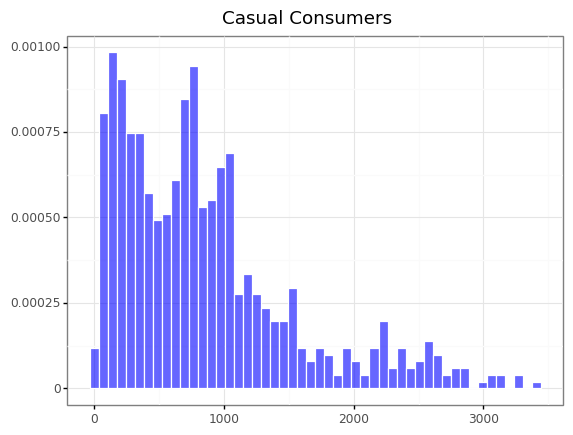

<ggplot: (-9223371881000576396)>

In [14]:
(df_day >>
     ggplot(aes("casual", y = "stat(density)"))+
        geom_histogram(bins = 50, fill = "blue", color = "white", alpha = 0.6)+
        labs(x = "", y = "", title = "Casual Consumers")+
        theme(legend_position = "none")+
        theme_bw())

Obsarvando o gráfico acima, a assimetria do histograma para a esquerda, indica que geralmente há mais casual consumers (locadores casuais) em dias com baixa contagem.

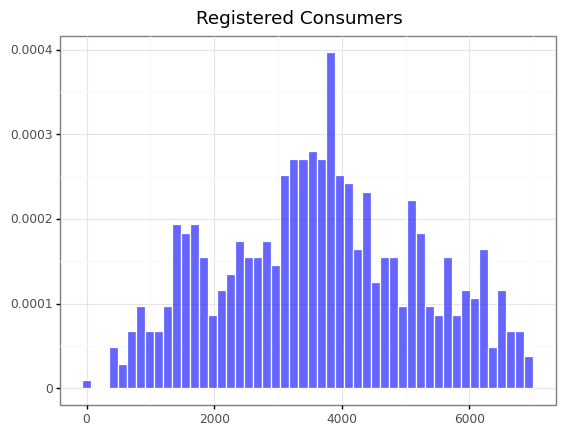

<ggplot: (155854204003)>

In [15]:
(df_day >>
     ggplot(aes("registered", y = "stat(density)"))+
        geom_histogram(bins = 50, fill = "blue", color = "white", alpha = 0.6)+
        labs(x = "", y = "", title = "Registered Consumers")+
        theme(legend_position = "none")+
        theme_bw())

Distribuição proxima a uma normal em relação aos consumidores registrados

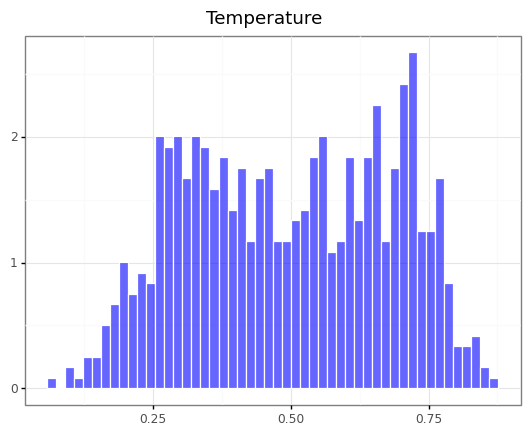

<ggplot: (155856808021)>

In [16]:
(df_day >>
     ggplot(aes("temp", y = "stat(density)"))+
        geom_histogram(bins = 50, fill = "blue", color = "white", alpha = 0.6)+
        labs(x = "", y = "", title = "Temperature")+
        theme(legend_position = "none")+
        theme_bw())

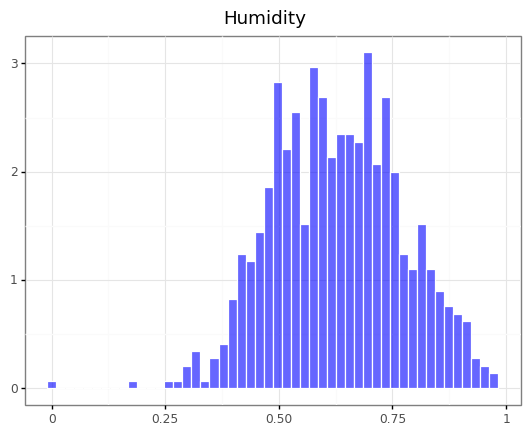

<ggplot: (155856817058)>

In [17]:
(df_day >>
     ggplot(aes("hum", y = "stat(density)"))+
        geom_histogram(bins = 50, fill = "blue", color = "white", alpha = 0.6)+
        labs(x = "", y = "", title = "Humidity")+
        theme(legend_position = "none")+
        theme_bw())

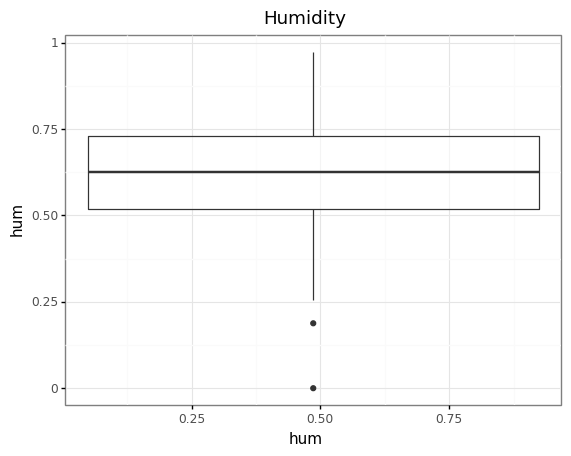

<ggplot: (-9223371880998001590)>

In [18]:
(df_day >>
     ggplot(aes("hum","hum"))+
        geom_boxplot(alpha = 0.6)+
        labs(title = "Humidity")+
        theme(legend_position = "none")+
        theme_bw())

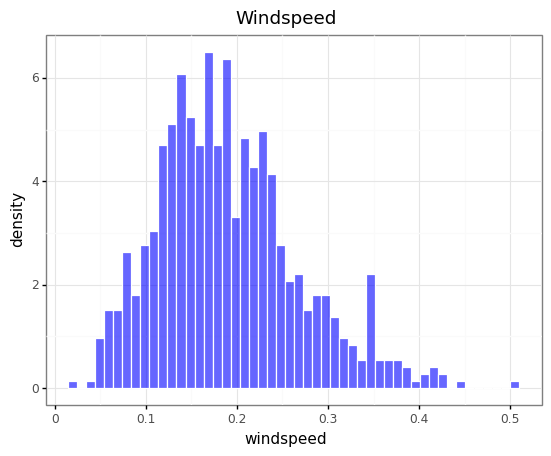

<ggplot: (-9223371880997658119)>

In [19]:
(df_day >>
     ggplot(aes("windspeed", y = "stat(density)"))+
        geom_histogram(bins = 50, fill = "blue", color = "white", alpha = 0.6)+
        labs(title = "Windspeed")+
        theme(legend_position = "none")+
        theme_bw())

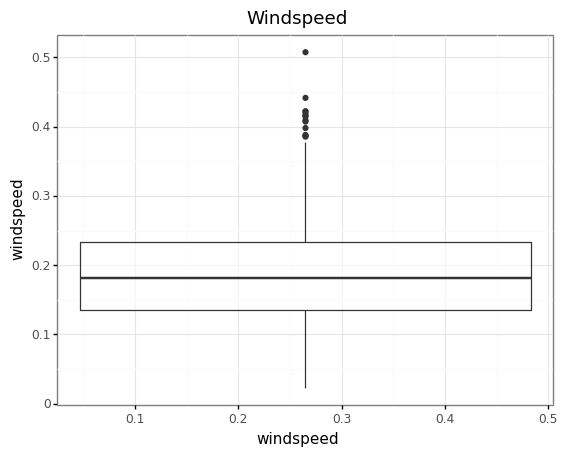

<ggplot: (155857136255)>

In [20]:
(df_day >>
     ggplot(aes("windspeed","windspeed"))+
        geom_boxplot(alpha = 0.6)+
        labs(title = "Windspeed")+
        theme(legend_position = "none")+
        theme_bw())

## Contagem em feriados

In [21]:
(df_day >>
     group_by(_.holiday)>>
     summarize(mean_holiday = _.cnt.mean(), median_holiday = _.cnt.median()))

,holiday,mean_holiday,median_holiday
0,No,4527.104225,4558.0
1,Yes,3735.000000,3351.0


In [22]:
(df_day_tidy>>
     group_by( _.holiday,  _.user)>>
     summarize(mean_holiday = _.rents.mean(), median_holiday = _.rents.median()))

,holiday,user,mean_holiday,median_holiday
0,No,casual,841.771831,711.5
1,No,registered,3685.332394,3691.0
2,Yes,casual,1064.714286,874.0
3,Yes,registered,2670.285714,2549.0


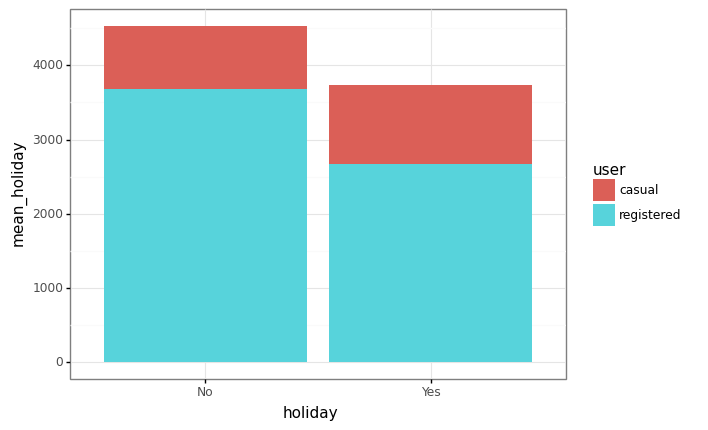

<ggplot: (155857204947)>

In [23]:
(df_day_tidy>>
     group_by( _.holiday,  _.user)>>
     summarize(mean_holiday = _.rents.mean())>>
     ggplot(aes("holiday", "mean_holiday", fill = "user"))+
        geom_bar(stat = "identity")+
        theme_bw())

Como mostrado no gráfico acima, a quantidade de aluguéis realizados pelo grupo de locadores registrados diminuem em feriados, enquanto os locadores casuais realizam mais aluguéis nesses dias. Assim, a hipótese de que os usuários registrados utilizam as bicicletas para necessidades pessoais, especialmente como meio de transporte, é criada, e a hipótese de que os usuários casuais realizam os aluguéis apenas como forma de lazer ou até mesmo prática de exercícios físicos, também é criada.

## Aluguéis ao longo do tempo

In [24]:
(df_day_tidy >>
     mutate(mnth = pd.Categorical(df_day_tidy["mnth"], categories =  ["Jan", "Feb", "Mar", "Apr", "Mai", "Jun", "Jul", "Aug", 
                                                                      "Sep", "Oct", "Nov", "Dec"])) >>
     group_by(_.mnth, _.yr, _.user)>>
     summarize(mean_cnt = _.rents.mean(), median_count = _.rents.median())>>
     head())

,mnth,yr,user,mean_cnt,median_count
0,Jan,2011,casual,99.129032,83.0
1,Jan,2011,registered,1132.774194,1137.0
2,Jan,2012,casual,289.322581,217.0
3,Jan,2012,registered,2831.451613,3040.0
4,Feb,2011,casual,222.928571,139.5


In [25]:
df_day_tidy["mnth_yr"] = df_day_tidy["mnth"].astype(str) + "/" + df_day_tidy["yr"].astype(str)

In [26]:
df_day_tidy.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,user,rents,mnth_yr
0,1,2011-01-01,Winter,2011,Jan,No,Saturday,No,Moderate,0.344167,0.363625,0.805833,0.160446,985,casual,331,Jan/2011
1,2,2011-01-02,Winter,2011,Jan,No,Sunday,No,Moderate,0.363478,0.353739,0.696087,0.248539,801,casual,131,Jan/2011
2,3,2011-01-03,Winter,2011,Jan,No,Monday,Yes,Good,0.196364,0.189405,0.437273,0.248309,1349,casual,120,Jan/2011
3,4,2011-01-04,Winter,2011,Jan,No,Tuesday,Yes,Good,0.200000,0.212122,0.590435,0.160296,1562,casual,108,Jan/2011
4,5,2011-01-05,Winter,2011,Jan,No,Wednesday,Yes,Good,0.226957,0.229270,0.436957,0.186900,1600,casual,82,Jan/2011


C:\Users\VICTOR HABIB\Anaconda3\lib\site-packages\plotnine\geoms\geom_path.py:83: PlotnineWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?


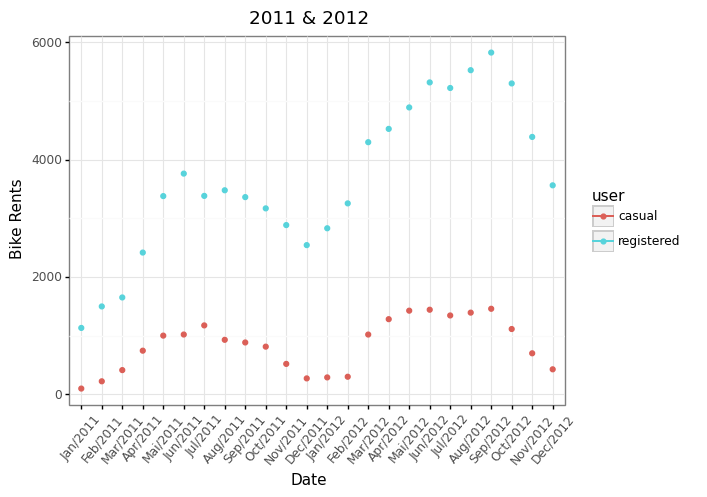

In [27]:
(df_day_tidy >>
    mutate(mnth_yr = pd.Categorical(df_day_tidy["mnth_yr"], categories =  ["Jan/2011", "Feb/2011", "Mar/2011", "Apr/2011", 
                                                                            "Mai/2011", "Jun/2011", "Jul/2011", "Aug/2011", 
                                                                            "Sep/2011", "Oct/2011", "Nov/2011", "Dec/2011", 
                                                                            "Jan/2012", "Feb/2012", "Mar/2012", "Apr/2012", 
                                                                            "Mai/2012", "Jun/2012", "Jul/2012", "Aug/2012", 
                                                                            "Sep/2012", "Oct/2012", "Nov/2012", "Dec/2012"])) >>
     group_by(_.mnth_yr, _.user)>>
     summarize(mean_cnt = _.rents.mean())>>
     ggplot(aes("mnth_yr", "mean_cnt", color = "user"))+
         geom_line(size = 0.75) +
         geom_point(size = 1.5)+
         labs(x = "Date", y = "Bike Rents", title = "2011 & 2012")+
         theme_bw()+
         theme(axis_text_x = element_text(angle = 50))).draw();


Ao observar o gráfico acima, algumas análises e conclusões podem ser realizadas sobre os aluguéis de bicicletas durante os meses dos anos de 2011 e 2012. Como já foi observado, a quantidade de aluguéis realizados por usuários registrados é muito superior quando comparado com os usuários casuais. Isso ocorre por conta do grande número de locadores registrados e pela frequência em que esses usuários efetuam os aluguéis. Além disso, nota-se um crescimento dos aluguéis de 2011 para 2012, que pode ser explicado pelo incentivo do uso de transportes que não emitem gases indesejáveis ao meio ambiente, condicionado pela política de sustentabilidade que iniciava naquela época. Outro fator que pode ser notado faz referência aos meses de menores aluguéis. Tanto em 2011, quanto em 2012, os meses de Dezembro, Janeiro e Fevereiro tiveram menos aluguéis tanto por parte dos registrados, quanto dos casuais. Esse acontecimento tende a se repetir sempre, e pode ser explicado pela coincidência com o período de férias trabalhistas, recesso escolar e feriados comemorativos de natal e fim de ano, em que, supostamente, as pessoas mudam a rotina, descansam ou, até mesmo, viajam. Além disso, o inverno estadunidense, especialemnte na região de Washington, é bastante intenso, com temperaturas atingindo valores próximos a 0°C, ou até mesmo, negativos, tornando a experiência do uso da bicicleta desagradável. 

In [28]:
(df_day_tidy >>
     group_by(_.yr, _.user)>>
     summarize(mean_cnt = _.rents.mean(), median_cnt = _.rents.median()))

,yr,user,mean_cnt,median_cnt
0,2011,casual,677.402740,614.0
1,2011,registered,2728.358904,2915.0
2,2012,casual,1018.483607,904.5
3,2012,registered,4581.450820,4776.5


In [29]:
df_day_tidy["weekday_yr"] = df_day_tidy["weekday"].astype(str) + "/" + df_day_tidy["yr"].astype(str)

In [30]:
df_day_tidy.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,user,rents,mnth_yr,weekday_yr
0,1,2011-01-01,Winter,2011,Jan,No,Saturday,No,Moderate,0.344167,0.363625,0.805833,0.160446,985,casual,331,Jan/2011,Saturday/2011
1,2,2011-01-02,Winter,2011,Jan,No,Sunday,No,Moderate,0.363478,0.353739,0.696087,0.248539,801,casual,131,Jan/2011,Sunday/2011
2,3,2011-01-03,Winter,2011,Jan,No,Monday,Yes,Good,0.196364,0.189405,0.437273,0.248309,1349,casual,120,Jan/2011,Monday/2011
3,4,2011-01-04,Winter,2011,Jan,No,Tuesday,Yes,Good,0.200000,0.212122,0.590435,0.160296,1562,casual,108,Jan/2011,Tuesday/2011
4,5,2011-01-05,Winter,2011,Jan,No,Wednesday,Yes,Good,0.226957,0.229270,0.436957,0.186900,1600,casual,82,Jan/2011,Wednesday/2011


C:\Users\VICTOR HABIB\Anaconda3\lib\site-packages\plotnine\geoms\geom_path.py:83: PlotnineWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?


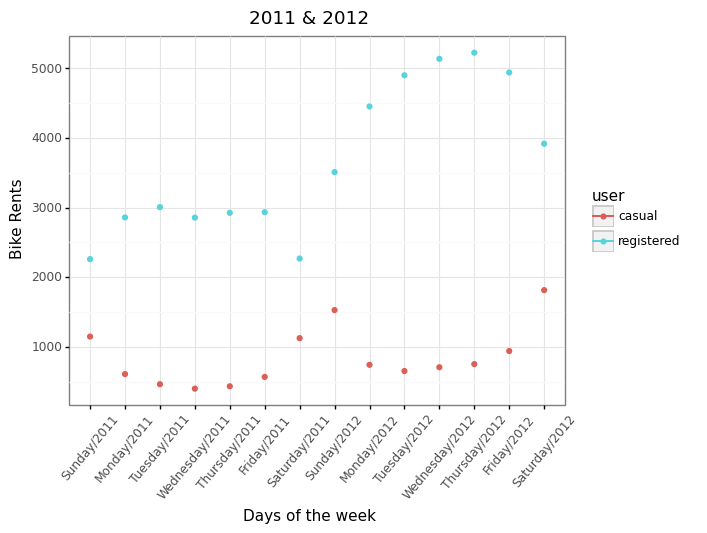

In [31]:
(df_day_tidy >>
    mutate(weekday_yr = pd.Categorical(df_day_tidy["weekday_yr"], categories =  ["Sunday/2011", "Monday/2011", "Tuesday/2011", 
                                                                                  "Wednesday/2011", "Thursday/2011", 
                                                                                  "Friday/2011", "Saturday/2011",
                                                                                  "Sunday/2012", "Monday/2012", "Tuesday/2012", 
                                                                                  "Wednesday/2012", "Thursday/2012", 
                                                                                  "Friday/2012", "Saturday/2012"])) >>
    group_by(_.weekday_yr, _.user)>>
    summarize(mean_cnt = _.rents.mean())>>
    ggplot(aes("weekday_yr", "mean_cnt", color = "user"))+
        geom_line(size = 0.75) +
        geom_point(size = 1.5)+
        labs(x = "Days of the week", y = "Bike Rents", title = "2011 & 2012")+
        theme_bw()+
        theme(axis_text_x = element_text(angle = 50))).draw();

Mais uma vez, como observado no gráfico de aluguéis de bicicletas conforme o dia da semana, que abrange os anos de 2011 e 2012, as hipóteses de que os usuários causuais são locadores de lazer, e de que os registrados utilizam a bicicleta como meio de transporte, são fortemente retificadas. Isso porque, aos sábados e domingos, o número de casuais que efetuam os aluguéis de bicicleta aumentam significativamente, enquanto os registrados deixam de realizar os aluguéis nessas datas. Além disso, pode-se observar novamente o crescimento no valor absoluto de aluguéis de bicicleta na cidade, resultado que provavelmente reflete o cenário sustentável do mundo inteiro.

## Usuários nas condições climáticas

C:\Users\VICTOR HABIB\Anaconda3\lib\site-packages\plotnine\geoms\geom_path.py:83: PlotnineWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?


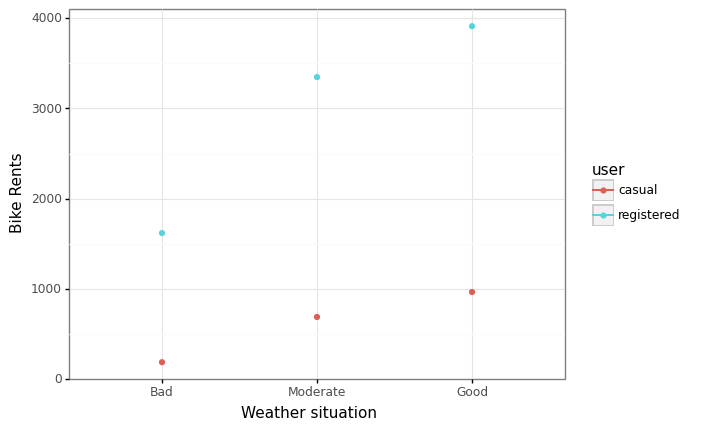

In [32]:
(df_day_tidy >>
     mutate(weathersit = pd.Categorical(df_day_tidy["weathersit"], categories =  ["Very Bad", "Bad", "Moderate", "Good" ])) >>
     group_by(_.user, _.weathersit)>>
     summarize(mean_cnt = _.rents.mean())>>
     ggplot(aes("weathersit", "mean_cnt", color = "user"))+
         geom_line(size = 0.75) +
         geom_point(size = 1.5)+
         labs(x = "Weather situation", y = "Bike Rents")+
         theme_bw()).draw();

Como observado no gráfico de aluguéis de bicicletas ao longo dos anos de 2011 e 2012 conforme as condições climáticas, é possível concluir que em dias de clima favorável, ou seja, ensolarado e sem previsões de chuva, os aluguéis são mais recorrentes, tanto para usuários casuais, quanto para usuários registrados. Enquanto isso, em dias em que o clima esteve desfavorável, a procura por bicicletas é bem menor. Olhando unicamente para a curva apresentada, é possível concluir que existe uma relação direta entre a condição climática e os aluguéis de biciletas, ou seja, quanto melhor o tempo, maior a quantidade de aluguéis realizados.

C:\Users\VICTOR HABIB\Anaconda3\lib\site-packages\plotnine\stats\smoothers.py:311: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.


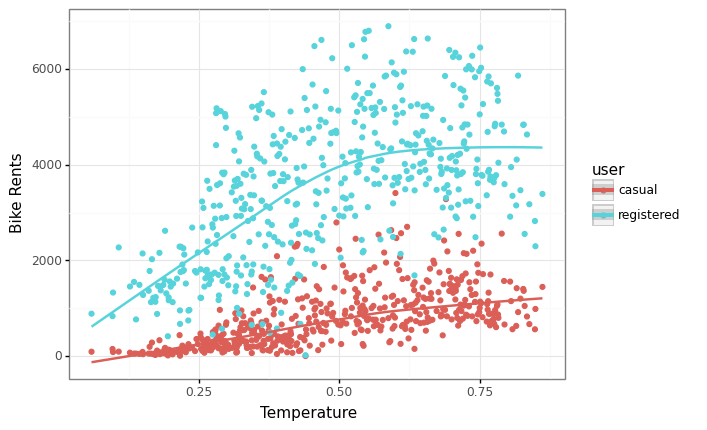

<ggplot: (155857117567)>

In [33]:
(df_day_tidy >>
     group_by(_.user, _.temp)>>
     summarize(mean_cnt = _.rents.mean())>>
     ggplot(aes("temp", "mean_cnt", color = "user"))+
        geom_point(size = 1.5)+
        geom_smooth()+ 
        labs(x = "Temperature", y = "Bike Rents")+
        theme_bw())

Seguindo o cenário climático, com o auxílio do gráfico acima, pode-se notar que também existe uma relação direta de temperatura com a quantidade de aluguéis realizados, muito semelhante com a relação observada entre a condição climática e os aluguéis. Isso já era de se esperar, já que a temperatura está atrelada às condições boas, moderadas e ruins de clima, e o gráfico acima valida essa hipótese. Entretanto, a partir de um certo valor de temperatura, já considerado elevado, a relação direta de proporcionalidade deixa de existir ao passo que há uma tendência de estabilidade na quantidade de aluguéis.

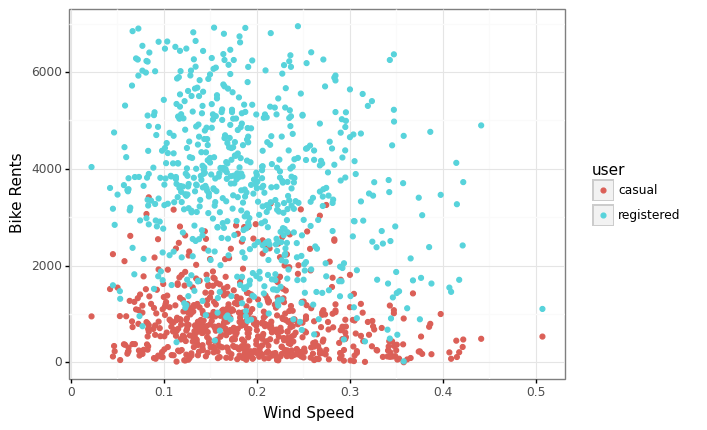

<ggplot: (-9223371881000570266)>

In [34]:
(df_day_tidy >>
     group_by(_.user, _.windspeed)>>
     summarize(mean_cnt = _.rents.mean())>>
     ggplot(aes("windspeed", "mean_cnt", color = "user"))+
        geom_point(size = 1.5)+
        #geom_smooth()+ 
        labs(x = "Wind Speed", y = "Bike Rents")+
        theme_bw())

Diferentemente das relações estabelecidas anteriormente, pode-se notar no gráfico acima que a velocidade do vento não influencia tanto na decisão do usuário em alugar uma bicicleta. Isso porque, esse parâmetro não é tão tangível quanto os indicadores de temperatura e condições climáticas, ou até mesmo desconsiderados pela população.

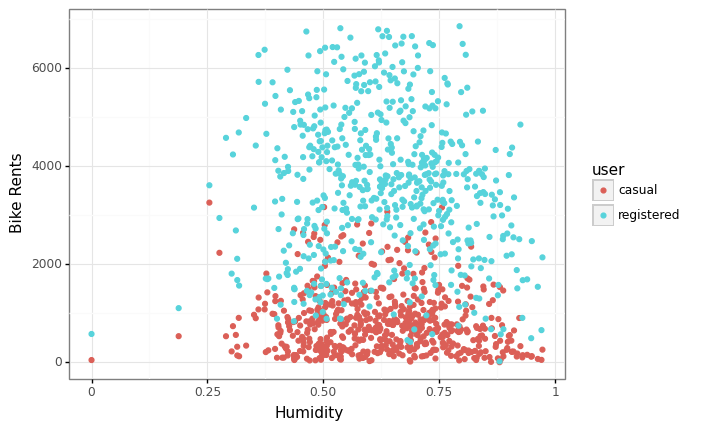

<ggplot: (-9223371880997984701)>

In [35]:
(df_day_tidy >>
     group_by(_.user, _.hum)>>
     summarize(mean_cnt = _.rents.mean())>>
     ggplot(aes("hum", "mean_cnt", color = "user"))+
        geom_point(size = 1.5)+
        #geom_smooth()+ 
        labs(x = "Humidity", y = "Bike Rents")+
        theme_bw())

Tão intangível quanto o parâmetro de velocidade do vento, a umidade deixa de ser considerada por muitos usuários na hora de alugar uma bicicleta. Assim, pode-se concluir que a umidade está longe de ser um fator determinante que influência nos aluguéis de bicicleta, não apresentando qualquer relação direta ou indireta com esse tema.

## Análise por horário do dia

In [36]:
df_hour.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [37]:
df_hour.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


In [38]:
df_hour.describe()

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,17379.0000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,8690.0000,2.501640,0.502561,6.537775,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869,189.463088
std,5017.0295,1.106918,0.500008,3.438776,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286,181.387599
min,1.0000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,4345.5000,2.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,40.000000
50%,8690.0000,3.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000
75%,13034.5000,3.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,281.000000
max,17379.0000,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000


In [39]:
df_hour_tidy = (df_hour >>
     gather("user", "rents", "casual", "registered"))

In [40]:
#Organizando

df_hour_tidy['weathersit'] = df_hour_tidy['weathersit'].replace([1,2,3,4],["Good", "Moderate", "Bad", "Very Bad"])
df_hour_tidy['weekday'] = df_hour_tidy['weekday'].replace([0,1,2,3,4,5,6],["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"])
df_hour_tidy['season'] = df_hour_tidy['season'].replace([1,2,3,4],["Winter", "Spring", "Summer", "Fall"])
df_hour_tidy['workingday'] = df_hour_tidy['workingday'].replace([0,1],["No","Yes"])
df_hour_tidy['holiday'] = df_hour_tidy['holiday'].replace([0,1],["No", "Yes"])
df_hour_tidy['yr'] = df_hour_tidy['yr'].replace([0,1],[2011, 2012])
df_hour_tidy['mnth'] = df_hour_tidy['mnth'].replace([1,2,3,4,5,6,7,8,9,10,11,12],["Jan", "Feb", "Mar", "Apr", "Mai", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])

df_hour_tidy['hr'] = df_hour_tidy['hr'].apply(str)

for i in range(0, len(df_hour_tidy)):
    if len(df_hour_tidy['hr'][i]) == 1:
        df_hour_tidy['hr'][i] = "0" + df_hour_tidy['hr'][i] + "h"
    else:
        df_hour_tidy['hr'][i] = df_hour_tidy['hr'][i] + "h"

C:\Users\VICTOR HABIB\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\VICTOR HABIB\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [41]:
df_hour_tidy.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,user,rents
0,1,2011-01-01,Winter,2011,Jan,00h,No,Saturday,No,Good,0.24,0.2879,0.81,0.0,16,casual,3
1,2,2011-01-01,Winter,2011,Jan,01h,No,Saturday,No,Good,0.22,0.2727,0.80,0.0,40,casual,8
2,3,2011-01-01,Winter,2011,Jan,02h,No,Saturday,No,Good,0.22,0.2727,0.80,0.0,32,casual,5
3,4,2011-01-01,Winter,2011,Jan,03h,No,Saturday,No,Good,0.24,0.2879,0.75,0.0,13,casual,3
4,5,2011-01-01,Winter,2011,Jan,04h,No,Saturday,No,Good,0.24,0.2879,0.75,0.0,1,casual,0


In [42]:
df_hour_tidy["day"] = range(0, len(df_hour_tidy))
for i in range(0, len(df_hour_tidy)):
    df_hour_tidy["day"][i] = df_hour_tidy.dteday[i][8:10]
    
df_hour_tidy = (df_hour_tidy >>
    select(_["instant": "mnth"], "day", _["hr": "rents"]))

C:\Users\VICTOR HABIB\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [43]:
df_hour_tidy.head()

,instant,dteday,season,yr,mnth,day,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,user,rents
0,1,2011-01-01,Winter,2011,Jan,1,00h,No,Saturday,No,Good,0.24,0.2879,0.81,0.0,16,casual,3
1,2,2011-01-01,Winter,2011,Jan,1,01h,No,Saturday,No,Good,0.22,0.2727,0.80,0.0,40,casual,8
2,3,2011-01-01,Winter,2011,Jan,1,02h,No,Saturday,No,Good,0.22,0.2727,0.80,0.0,32,casual,5
3,4,2011-01-01,Winter,2011,Jan,1,03h,No,Saturday,No,Good,0.24,0.2879,0.75,0.0,13,casual,3
4,5,2011-01-01,Winter,2011,Jan,1,04h,No,Saturday,No,Good,0.24,0.2879,0.75,0.0,1,casual,0


In [44]:
df_hour_tidy.describe()

,instant,yr,day,temp,atemp,hum,windspeed,cnt,rents
count,34758.000000,34758.000000,34758.000000,34758.000000,34758.000000,34758.000000,34758.000000,34758.000000,34758.000000
mean,8690.000000,2011.502561,15.683411,0.496987,0.475775,0.627229,0.190098,189.463088,94.731544
std,5016.957326,0.500001,8.789247,0.192553,0.171848,0.192927,0.122338,181.384990,127.111267
min,1.000000,2011.000000,1.000000,0.020000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,4345.250000,2011.000000,8.000000,0.340000,0.333300,0.480000,0.104500,40.000000,9.000000
50%,8690.000000,2012.000000,16.000000,0.500000,0.484800,0.630000,0.194000,142.000000,43.000000
75%,13034.750000,2012.000000,23.000000,0.660000,0.621200,0.780000,0.253700,281.000000,134.000000
max,17379.000000,2012.000000,31.000000,1.000000,1.000000,1.000000,0.850700,977.000000,886.000000


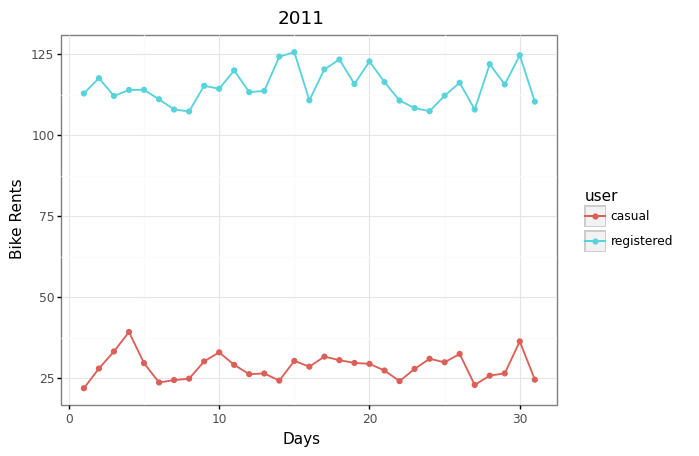

In [45]:
(df_hour_tidy >>
     group_by(_.user, _.day)>>
     filter(_.yr == 2011)>>
     summarize(mean_cnt = _.rents.mean())>>
     ggplot(aes("day", "mean_cnt", color = "user"))+
         geom_line(size = 0.75) +
         geom_point(size = 1.5)+
         labs(x = "Days", y = "Bike Rents", title = "2011")+
         theme_bw()).draw();

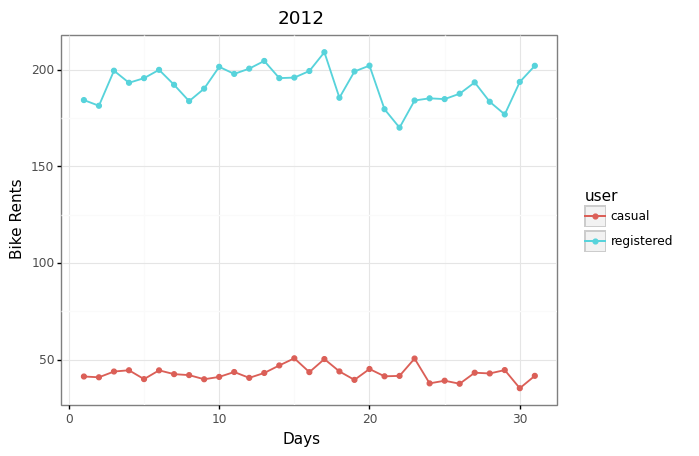

In [46]:
(df_hour_tidy >>
    group_by(_.user, _.day)>>
    filter(_.yr == 2012)>>
    summarize(mean_cnt = _.rents.mean())>>
    ggplot(aes("day", "mean_cnt", color = "user"))+
        geom_line(size = 0.75) +
        geom_point(size = 1.5)+
        labs(x = "Days", y = "Bike Rents", title = "2012")+
        theme_bw()).draw();

Como pode-se observar nos gráficos acima, que representam as médias dos aluguéis conforme os dias do mês dos anos de 2011 e 2012, não é possível concluir qualquer fator relevante que facilite entender o comportamento dos aluguéis, já que não há uma padronização concreta.

C:\Users\VICTOR HABIB\Anaconda3\lib\site-packages\plotnine\stats\stat_smooth.py:202: PlotnineWarning: Smoothing requires 2 or more points. Got 1. Not enough points for smoothing. If this message a surprise, make sure the column mapped to the x aesthetic has the right dtype.
C:\Users\VICTOR HABIB\Anaconda3\lib\site-packages\plotnine\geoms\geom_path.py:83: PlotnineWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?


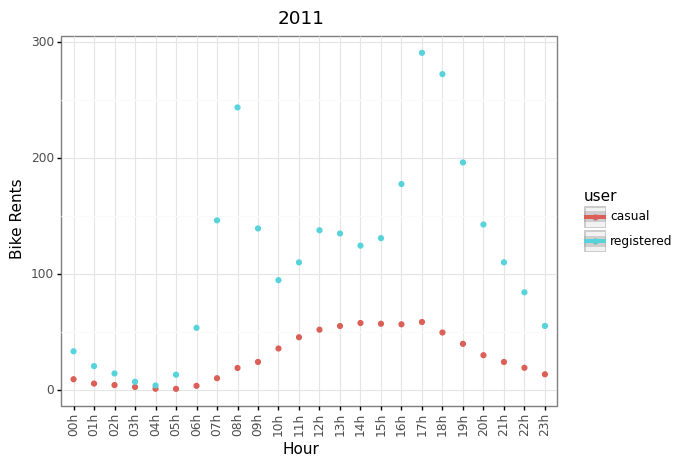

In [47]:
(df_hour_tidy >>
    mutate(hr = pd.Categorical(df_hour_tidy["hr"], categories =  ["00h", "01h", "02h", "03h", "04h", "05h", "06h", "07h", "08h", 
                                                                   "09h", "10h", "11h", "12h", "13h", "14h", "15h", "16h", 
                                                                   "17h", "18h", "19h", "20h", "21h", "22h", "23h"])) >>
    group_by(_.user, _.hr)>>
    filter(_.yr == 2011)>>
    summarize(mean_cnt = _.rents.mean())>>
    ggplot(aes("hr", "mean_cnt", color = "user"))+
        geom_line(size = 0.75) +
        geom_point(size = 1.5)+
        geom_smooth()+ 
        labs(x = "Hour", y = "Bike Rents", title = "2011")+
        theme_bw()+
        theme(axis_text_x = element_text(angle = 90))).draw();

C:\Users\VICTOR HABIB\Anaconda3\lib\site-packages\plotnine\stats\stat_smooth.py:202: PlotnineWarning: Smoothing requires 2 or more points. Got 1. Not enough points for smoothing. If this message a surprise, make sure the column mapped to the x aesthetic has the right dtype.
C:\Users\VICTOR HABIB\Anaconda3\lib\site-packages\plotnine\geoms\geom_path.py:83: PlotnineWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?


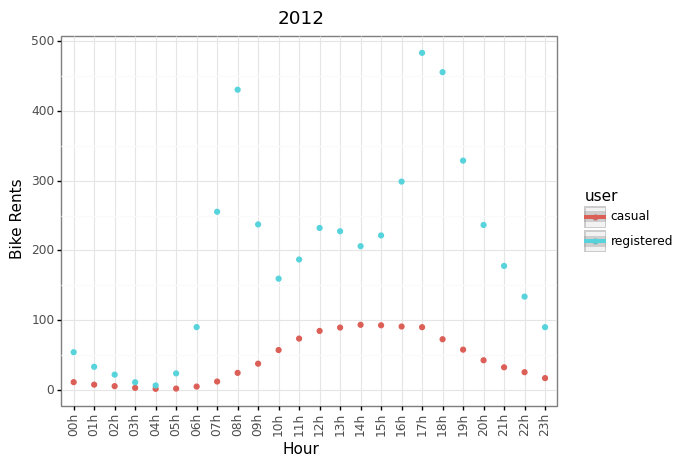

In [48]:
(df_hour_tidy >>
    mutate(hr = pd.Categorical(df_hour_tidy["hr"], categories =  ["00h", "01h", "02h", "03h", "04h", "05h", "06h", "07h", "08h", 
                                                                   "09h", "10h", "11h", "12h", "13h", "14h", "15h", "16h", 
                                                                   "17h", "18h", "19h", "20h", "21h", "22h", "23h"])) >>
    filter(_.yr == 2012)>>    
    group_by(_.user, _.hr)>>
    summarize(mean_cnt = _.rents.mean())>>
    ggplot(aes("hr", "mean_cnt", color = "user"))+
        geom_line(size = 0.75) +
        geom_point(size = 1.5)+
        geom_smooth()+ 
        labs(x = "Hour", y = "Bike Rents", title = "2012")+
        theme_bw()+
        theme(axis_text_x = element_text(angle = 90))).draw();

Como pode-se observar nos gráficos referentes aos anos de 2011 e 2012, os aluguéis mantiveram características semelhantes nos dois anos, variando, no geral, apenas o número absoluto. Sobre os registrados, eles costumam alugar nos períodos de rush: 8h da manhã (antecede a hora de início do expediente comercial -> supostamente alugam bicicletas para irem ao trabalho) e entre 16 e 17h (fim do expediente -> supostamente alugam bicicletas para irem para casa). Enquanto isso, os locadores casuais costumam realizar os aluguéis durante a tarde, período que representa o horário de lazer.

Para finalizar a análise, foi realizado um gráfico traçando a correlação entre as variáveis para ver se algum aspecto que ainda não foi analisado, se relaciona entre si:

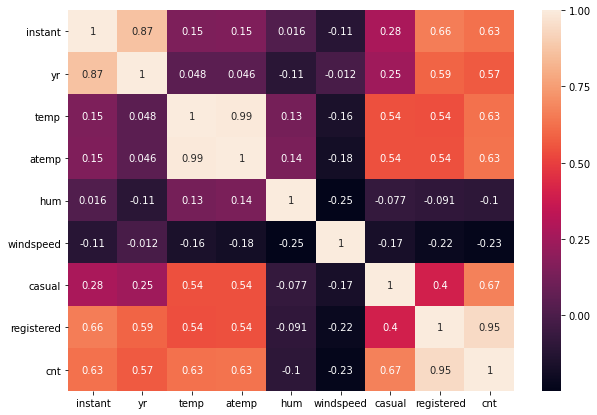

In [49]:
fig, ax = plt.subplots(figsize = (10, 7))
sns.heatmap(df_day.corr(), annot = True)
plt.show()

Pode-se perceber que não há nenhuma correlação relevante identificada entre as variáveis.

# Conclusão da análise exploratória

Como observado ao longo do documento, os dados coletados de usuários casuais e registrados tendem a ter comportamentos semelhantes, porém em proporções completamente diferentes. Como pode ser notado, o número de locadores registrados e a frequência com que esse grupo realiza os aluguéis, são os fatores principais que explicam a discrepância nos valores absolutos em toda a análise.

O DataFrame dos aluguéis de bicicletas realizados ao longo dos dias serviu de base para realizar a maioria das análises das relações existentes entre o aluguel de bicicletas e as variáveis independentes, como: dia da semana, condição climática, temperatura, velocidade do vento, umidade, entre outras. Como especificado durante todo o relatório, algumas variáveis influenciam de alguma forma a variável dependente do sistema, enquanto outras não apresentam qualquer significado conclusivo.

Como pode-se observar, a procura por bicicletas aumentou significativamente em Washington ao decorrer dos anos de 2011 e 2012. Esse ambiente ganha força no cenário mundial, em que o tema de sustentabilidade atrelado a redução da emissão de gases é pauta global. Nesse setor, os resultados ganham ainda mais força, uma vez que a bicicleta é o transporte popular que mais se encaixa nessas condições sustentáveis. À medida que incentivos referentes a esse assunto são dados, maior a tendência de aceitação por parte da população em mudar seus hábitos a fim de proporcionar um ambiente mais suadável para todos. É inegável que o interesse em se adaptar a esse hábito e efetivamente utilizar mais as bicicletas como meio de transporte não se restringe apenas a esses incentivos e à simples mudanças de rotina. Sabe-se que as condições geográfica da região é fator determinante para implementação dessa política nas cidades. Como sabido, Washington é uma cidade urbanizada, plana e com infraestrutura suficiente para acolher esse sistema. 

A análise exploratória foi concluida e os resultados obtidos foram fundamentais para implementar o modelo preditivo adiante.

# Modelos Preditivos

Com a análise exploratória finalizada, partimos em busca de responder a pergunta inicial proposta no começo desse documento e assim criar modelos preditivos para conseguir prever o aluguel diário de bicicletas baseado nas condições adversas do dia. Destarte, com esse objetivo, foram criados 3 modelos diferentes, cada um para calcular um aspecto em específico: os alugueis totais, os alugueis para usuários registrados e os alugueis para usuários esporádicos (casuais).

1 - Prevendo contagem de alugueis por dia

2 - Prevendo contagem de alugueis para usuários registrados diariamente

3 - Prevendo contagem de alugueis para usuários casuais diariamente

In [50]:
df_day.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,Winter,2011,Jan,No,Saturday,No,Moderate,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,Winter,2011,Jan,No,Sunday,No,Moderate,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,Winter,2011,Jan,No,Monday,Yes,Good,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,Winter,2011,Jan,No,Tuesday,Yes,Good,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,Winter,2011,Jan,No,Wednesday,Yes,Good,0.226957,0.229270,0.436957,0.186900,82,1518,1600


# Divisão do Conjunto de Dados em Teste e Treinamento

Para selecionar um conjunto de testes, basta escolher aleatoriamente algumas amostras do conjunto original. Tipicamente selecionamos 20% da amostra para testes. Os demais pontos de dados serão o conjunto de treinamento.

Isto pode ser feito com Scikit-Learn usando a função ``train_test_split()``:

In [51]:
train_set, test_set = train_test_split(
    df_day, # DataFrame a ser Analisado
    test_size=0.2, #amostra de teste 20% e de treinamento 80%
    random_state=RANDOM_SEED,
)

# Visualização da Amostra de Treinamento
train_set

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
460,461,2012-04-05,Spring,2012,Apr,No,Thursday,Yes,Good,0.435000,0.431163,0.374167,0.219529,1192,5265,6457
142,143,2011-05-23,Spring,2011,Mai,No,Monday,Yes,Moderate,0.631667,0.590296,0.810000,0.233842,836,3438,4274
202,203,2011-07-22,Summer,2011,Jul,No,Friday,Yes,Good,0.848333,0.840896,0.580417,0.133100,562,2825,3387
404,405,2012-02-09,Winter,2012,Feb,No,Thursday,Yes,Good,0.265000,0.261988,0.562083,0.194037,163,3667,3830
716,717,2012-12-17,Fall,2012,Dec,No,Monday,Yes,Moderate,0.393333,0.401500,0.907083,0.098258,212,4373,4585
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16,17,2011-01-17,Winter,2011,Jan,Yes,Monday,No,Moderate,0.175833,0.176771,0.537500,0.194017,117,883,1000
58,59,2011-02-28,Winter,2011,Feb,No,Monday,Yes,Moderate,0.407273,0.400118,0.876364,0.289686,81,1365,1446
277,278,2011-10-05,Fall,2011,Oct,No,Wednesday,Yes,Good,0.538333,0.527138,0.647917,0.177250,559,4267,4826
255,256,2011-09-13,Summer,2011,Sep,No,Tuesday,Yes,Good,0.650833,0.603554,0.712500,0.141804,701,4062,4763


In [52]:
# Verificando a Divisão
print(f'{len(train_set)} train + {len(test_set)} test = '
      f'{len(train_set) + len(test_set)} amostras')

584 train + 147 test = 731 amostras


In [53]:
# Verificando a Correlação entre as Variáveis (Pearson)
train_set.corr()

,instant,yr,temp,atemp,hum,windspeed,casual,registered,cnt
instant,1.000000,0.867624,0.156822,0.162041,0.035616,-0.104275,0.291039,0.658833,0.633029
yr,0.867624,1.000000,0.032181,0.035448,-0.100778,-0.017534,0.249965,0.586626,0.560426
temp,0.156822,0.032181,1.000000,0.996579,0.153841,-0.167824,0.537364,0.543913,0.627001
atemp,0.162041,0.035448,0.996579,1.000000,0.163382,-0.190299,0.542184,0.553446,0.636374
hum,0.035616,-0.100778,0.153841,0.163382,1.000000,-0.258174,-0.058344,-0.083539,-0.087801
windspeed,-0.104275,-0.017534,-0.167824,-0.190299,-0.258174,1.000000,-0.193349,-0.230424,-0.253571
casual,0.291039,0.249965,0.537364,0.542184,-0.058344,-0.193349,1.000000,0.401877,0.675134
registered,0.658833,0.586626,0.543913,0.553446,-0.083539,-0.230424,0.401877,1.000000,0.946823
cnt,0.633029,0.560426,0.627001,0.636374,-0.087801,-0.253571,0.675134,0.946823,1.000000


Análise se existe correlação entre a variável dependente e as demais independentes

In [54]:
train_set.copy().corr()['cnt'].sort_values(ascending=False)

cnt           1.000000
registered    0.946823
casual        0.675134
atemp         0.636374
instant       0.633029
temp          0.627001
yr            0.560426
hum          -0.087801
windspeed    -0.253571
Name: cnt, dtype: float64

# Modelo 1. (contagem de alugueis por dia)

### 1) Separar a variável dependente das variáveis independentes

In [55]:
# Variáveis independentes: dataset original menos a coluna de valores dependentes.
X_train_cover = train_set.drop(columns=['cnt']) 
y_train_cover_label = train_set['cnt'] 

### 2) Separar também as variáveis Numéricas e Categóricas

In [56]:
# Dataframe das Variáveis Numéricas
# Retirar as Colunas das Variáveis Categóricas
df_num = X_train_cover.drop(['dteday', 'season', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit'], axis=1) 
df_num.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
instant,584.0,366.272260,212.603690,1.000000,181.500000,371.500000,547.250000,731.000000
yr,584.0,2011.510274,0.500323,2011.000000,2011.000000,2012.000000,2012.000000,2012.000000
temp,584.0,0.494907,0.183500,0.059130,0.336458,0.510417,0.653541,0.861667
atemp,584.0,0.474020,0.163641,0.079070,0.337628,0.495881,0.607975,0.840896
hum,584.0,0.630534,0.142604,0.187917,0.520000,0.634167,0.731562,0.972500
windspeed,584.0,0.191568,0.077830,0.022392,0.134798,0.182837,0.235242,0.507463
casual,584.0,848.203767,681.965340,2.000000,328.500000,727.500000,1094.250000,3410.000000
registered,584.0,3646.015411,1563.563060,20.000000,2499.000000,3674.000000,4747.000000,6946.000000


In [57]:
# Dataframe das Variáveis Categóricas
df_cat = X_train_cover[['dteday', 'season', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit']]

print(type(df_cat))
print(df_cat.head())

<class 'pandas.core.frame.DataFrame'>
         dteday  season mnth holiday   weekday workingday weathersit
460  2012-04-05  Spring  Apr      No  Thursday        Yes       Good
142  2011-05-23  Spring  Mai      No    Monday        Yes   Moderate
202  2011-07-22  Summer  Jul      No    Friday        Yes       Good
404  2012-02-09  Winter  Feb      No  Thursday        Yes       Good
716  2012-12-17    Fall  Dec      No    Monday        Yes   Moderate


### 3) Normalização dos Dados

In [58]:
# Pipeline para as Variáveis Numéricas

meu_imputer = SimpleImputer(strategy='median') #Valores Faltantes Substituídos pela Mediana
meu_scaler = StandardScaler()

num_pipeline = Pipeline([
    ('imputer', meu_imputer),
    ('std_scaler', meu_scaler),
])

df_num_tr = num_pipeline.fit_transform(df_num)
df_num_tr

array([[ 0.44594215,  0.97965889, -0.32674754, ...,  0.35956364,
         0.50455784,  1.03633331],
       [-1.05108084, -1.02076346,  0.74592808, ...,  0.54362099,
        -0.01791034, -0.1331534 ],
       [-0.76862367, -1.02076346,  1.92768372, ..., -0.75186603,
        -0.42003472, -0.52554276],
       ...,
       [-0.41555221, -1.02076346,  0.23685891, ..., -0.18412118,
        -0.42443754,  0.3975004 ],
       [-0.51911984, -1.02076346,  0.85046469, ..., -0.63993735,
        -0.21603731,  0.2662772 ],
       [-0.21312457, -1.02076346, -0.83581125, ...,  1.46332907,
        -1.04083258, -0.46857269]])

In [59]:
# Cria o codificador para Variável Categórica

meu_one_hot_encoder = OneHotEncoder(sparse=False)

cat_pipeline = Pipeline([
    ('cat_encoder', meu_one_hot_encoder),
])

df_cat_tr = cat_pipeline.fit_transform(df_cat)
df_cat_tr

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [60]:
# Pipeline para as Variáveis Categóricas e Numéricas

num_attribs = list(df_num)
cat_attribs = ['dteday', 'season', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit']

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', cat_pipeline, cat_attribs),
])

df_prepared = full_pipeline.fit_transform(X_train_cover)
df_prepared[:3]

array([[ 0.44594215,  0.97965889, -0.32674754, ...,  0.        ,
         1.        ,  0.        ],
       [-1.05108084, -1.02076346,  0.74592808, ...,  0.        ,
         0.        ,  1.        ],
       [-0.76862367, -1.02076346,  1.92768372, ...,  0.        ,
         1.        ,  0.        ]])

### 4) Modelos Preditivos de Regressões

### Regressão Linear

In [61]:
lin_reg = LinearRegression()
lin_reg.fit(df_prepared, y_train_cover_label)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [62]:
# Seleciona 5 pontos do conjunto de treinamento.
some_data = X_train_cover.iloc[:5]
some_labels = y_train_cover_label.iloc[:5]

In [63]:
some_data

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered
460,461,2012-04-05,Spring,2012,Apr,No,Thursday,Yes,Good,0.435000,0.431163,0.374167,0.219529,1192,5265
142,143,2011-05-23,Spring,2011,Mai,No,Monday,Yes,Moderate,0.631667,0.590296,0.810000,0.233842,836,3438
202,203,2011-07-22,Summer,2011,Jul,No,Friday,Yes,Good,0.848333,0.840896,0.580417,0.133100,562,2825
404,405,2012-02-09,Winter,2012,Feb,No,Thursday,Yes,Good,0.265000,0.261988,0.562083,0.194037,163,3667
716,717,2012-12-17,Fall,2012,Dec,No,Monday,Yes,Moderate,0.393333,0.401500,0.907083,0.098258,212,4373


In [64]:
some_labels

460    6457
142    4274
202    3387
404    3830
716    4585
Name: cnt, dtype: int64

In [65]:
# Prepara os dados
some_data_prepared = full_pipeline.transform(some_data)
some_data_prepared

array([[ 0.44594215,  0.97965889, -0.32674754, ...,  0.        ,
         1.        ,  0.        ],
       [-1.05108084, -1.02076346,  0.74592808, ...,  0.        ,
         0.        ,  1.        ],
       [-0.76862367, -1.02076346,  1.92768372, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.18231546,  0.97965889, -1.25397404, ...,  0.        ,
         1.        ,  0.        ],
       [ 1.65109273,  0.97965889, -0.55401075, ...,  0.        ,
         0.        ,  1.        ]])

In [66]:
# Para obter as previsões, basta chamar o método predict()
predicted_labels = lin_reg.predict(some_data_prepared)
print('Predição: {}'.format(predicted_labels.round(decimals=2)))

# Compare com os valores originais:
print('Original: {}'.format(some_labels.values.round(decimals=2)))

Predição: [6457. 4274. 3387. 3830. 4585.]
Original: [6457 4274 3387 3830 4585]


In [67]:
df_predictions = lin_reg.predict(df_prepared)
lin_mse = mean_squared_error(y_train_cover_label, df_predictions)
lin_rmse = np.sqrt(lin_mse)
print('Regressão linear: RMSE = {:.2f}'.format(lin_rmse))

Regressão linear: RMSE = 0.00


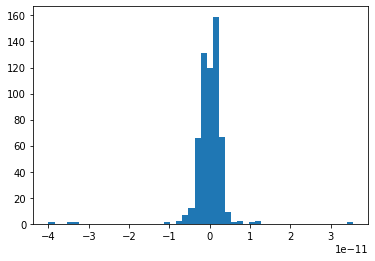

In [68]:
residuo = y_train_cover_label - df_predictions
plt.hist(residuo, bins=50);

In [69]:
pd.Series(residuo).describe()

count    5.840000e+02
mean    -1.136868e-13
std      3.799722e-12
min     -4.001777e-11
25%     -1.818989e-12
50%      0.000000e+00
75%      1.818989e-12
max      3.547029e-11
Name: cnt, dtype: float64

#### Regressor Random Forest

In [70]:
forest_reg = RandomForestRegressor(n_estimators=10, random_state=RANDOM_SEED)

X_train, X_test, y_train, y_test = train_test_split(
    df_prepared,
    y_train_cover_label,
    test_size=0.2,
    random_state=RANDOM_SEED,
)

forest_reg.fit(X_train, y_train)

y_pred = forest_reg.predict(X_test)
forest_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('Regressão random forest: RMSE = {:.2f}'.format(forest_rmse))

Regressão random forest: RMSE = 194.31


#### Árvore de Decisão

In [71]:
tree_reg = DecisionTreeRegressor(random_state=RANDOM_SEED)
tree_reg.fit(X_train, y_train)

y_pred = tree_reg.predict(X_test)
tree_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('Regressão árvore de decisão: RMSE = {:.2f}'.format(tree_rmse))

Regressão árvore de decisão: RMSE = 295.82


### Avaliação do melhor Regressor

Podemos repetir esses experimentos com partições diferentes e ver se o resultado se mantém. O scikit-learn já tem ferramentas para ajudar nessa tarefa:

O código acima executa ***n-fold cross validation*** (neste caso, $n=10$). A função ``cross_val_score`` divide o conjunto de treinamento em $n$ partes e executa o procedimento de testes (treinar modelo, prever, medir erro) $n$ vezes - uma para cada partição. A cada ensaio a partição da vez é separada como conjunto de teste, e as demais compõe o conjunto de treinamento.

Uma vantagem desta abordagem é que agora podemos ver a faixa de desempenhos do modelo.

In [72]:
# Regressão Linear

lin_scores = cross_val_score(
    lin_reg,  # modelo
    df_prepared,  # X_train
    y_train_cover_label,  # y_train
    scoring='neg_mean_squared_error',  # metrica de interesse
    cv=10,  # Quantas partições eu quero
    n_jobs=-1,  # Use todos os cores da maquina!
)
lin_rmse_scores = np.sqrt(-lin_scores)


def display_scores(scores):
    print('Scores:', scores.round(decimals=2))
    print('Mean:', scores.mean())
    print('Standard deviation:', scores.std())


display_scores(lin_rmse_scores)

C:\Users\VICTOR HABIB\Anaconda3\lib\site-packages\sklearn\externals\joblib\numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.


Scores: [ 9.6  11.68  6.83 17.95 20.1  12.97 10.09  8.71 19.68  8.58]
Mean: 12.617970083395038
Standard deviation: 4.647043814260703


In [73]:
# Random Forest

forest_scores = cross_val_score(
    forest_reg,
    df_prepared,
    y_train_cover_label,
    scoring='neg_mean_squared_error',
    cv=10,
    n_jobs=-1,
)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

C:\Users\VICTOR HABIB\Anaconda3\lib\site-packages\sklearn\externals\joblib\numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.


Scores: [206.79 175.36 110.5  103.65 172.07 222.4  130.38 215.43 169.7  141.96]
Mean: 164.82323259388517
Standard deviation: 40.28279615678505


In [74]:
# Decision Tree

tree_scores = cross_val_score(
    tree_reg,
    df_prepared,
    y_train_cover_label,
    scoring='neg_mean_squared_error',
    cv=10,
    n_jobs=-1,
)
tree_rmse_scores = np.sqrt(-tree_scores)
display_scores(tree_rmse_scores)

Scores: [396.8  264.73 197.9  185.6  217.05 325.07 179.85 216.62 247.68 244.4 ]
Mean: 247.57154957149072
Standard deviation: 64.31285827816284


C:\Users\VICTOR HABIB\Anaconda3\lib\site-packages\sklearn\externals\joblib\numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.


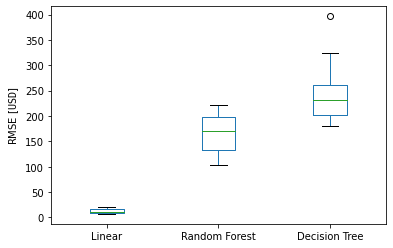

In [75]:
pd.DataFrame({
    'Linear': lin_rmse_scores,
    'Random Forest': forest_rmse_scores,
    'Decision Tree': tree_rmse_scores,
}).plot.box(
    xlabel='Regressor',
    ylabel=r'RMSE $[\mathtt{USD}]$',
    figsize=(6, 4),
);

A regressão linear é o melhor modelo de regressão para prever o número de bicicletas alugadas por dia em Washington, já que apresentou o menor erro médio quadrático (RMSE). Normalmente, modelos como Random Forest superam a acurácia apresentada pos modelos baseados na lógica da regressão linear. Entretanto, acredita-se que a base de dados comprometeu tal conclusão. Para futuras implementações, recomenda-se apresentar uma base de dados mais completa.

# Modelo 2. (contagem de alugueis para registrados, por dia)

#### 1) Separar a variável dependente das variáveis independentes

In [76]:
# Variáveis independentes: dataset original menos a coluna de valores dependentes.
X_train_cover = train_set.drop(columns=['registered']) 
y_train_cover_label = train_set['registered'] 

#### 2) Separar as variáveis Numéricas e Categóricas

In [77]:
# Dataframe das Variáveis Numéricas
# Retirar as Colunas das Variáveis Categóricas
df_num = X_train_cover.drop(['dteday', 'season', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit'], axis=1) 
df_num.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
instant,584.0,366.272260,212.603690,1.000000,181.500000,371.500000,547.250000,731.000000
yr,584.0,2011.510274,0.500323,2011.000000,2011.000000,2012.000000,2012.000000,2012.000000
temp,584.0,0.494907,0.183500,0.059130,0.336458,0.510417,0.653541,0.861667
atemp,584.0,0.474020,0.163641,0.079070,0.337628,0.495881,0.607975,0.840896
hum,584.0,0.630534,0.142604,0.187917,0.520000,0.634167,0.731562,0.972500
windspeed,584.0,0.191568,0.077830,0.022392,0.134798,0.182837,0.235242,0.507463
casual,584.0,848.203767,681.965340,2.000000,328.500000,727.500000,1094.250000,3410.000000
cnt,584.0,4494.219178,1940.836228,22.000000,3128.250000,4551.000000,5922.500000,8714.000000


In [78]:
# Dataframe das Variáveis Categóricas
df_cat = X_train_cover[['dteday', 'season', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit']]

print(type(df_cat))
print(df_cat.head())

<class 'pandas.core.frame.DataFrame'>
         dteday  season mnth holiday   weekday workingday weathersit
460  2012-04-05  Spring  Apr      No  Thursday        Yes       Good
142  2011-05-23  Spring  Mai      No    Monday        Yes   Moderate
202  2011-07-22  Summer  Jul      No    Friday        Yes       Good
404  2012-02-09  Winter  Feb      No  Thursday        Yes       Good
716  2012-12-17    Fall  Dec      No    Monday        Yes   Moderate


#### 3) Normalização dos Dados

In [79]:
# Pipeline para as Variáveis Numéricas

meu_imputer = SimpleImputer(strategy='median') #Valores Faltantes Substituídos pela Mediana
meu_scaler = StandardScaler()

num_pipeline = Pipeline([
    ('imputer', meu_imputer),
    ('std_scaler', meu_scaler),
])

df_num_tr = num_pipeline.fit_transform(df_num)
df_num_tr

array([[ 0.44594215,  0.97965889, -0.32674754, ...,  0.35956364,
         0.50455784,  1.01217373],
       [-1.05108084, -1.02076346,  0.74592808, ...,  0.54362099,
        -0.01791034, -0.1135634 ],
       [-0.76862367, -1.02076346,  1.92768372, ..., -0.75186603,
        -0.42003472, -0.57097469],
       ...,
       [-0.41555221, -1.02076346,  0.23685891, ..., -0.18412118,
        -0.42443754,  0.1710939 ],
       [-0.51911984, -1.02076346,  0.85046469, ..., -0.63993735,
        -0.21603731,  0.13860584],
       [-0.21312457, -1.02076346, -0.83581125, ...,  1.46332907,
        -1.04083258, -0.74321298]])

In [80]:
# Cria o codificador para Variável Categórica

meu_one_hot_encoder = OneHotEncoder(sparse=False)

cat_pipeline = Pipeline([
    ('cat_encoder', meu_one_hot_encoder),
])

df_cat_tr = cat_pipeline.fit_transform(df_cat)
df_cat_tr

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [81]:
# Pipeline para as Variáveis Categóricas e Numéricas

num_attribs = list(df_num)
cat_attribs = ['dteday', 'season', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit']

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', cat_pipeline, cat_attribs),
])

df_prepared = full_pipeline.fit_transform(X_train_cover)
df_prepared[:3]

array([[ 0.44594215,  0.97965889, -0.32674754, ...,  0.        ,
         1.        ,  0.        ],
       [-1.05108084, -1.02076346,  0.74592808, ...,  0.        ,
         0.        ,  1.        ],
       [-0.76862367, -1.02076346,  1.92768372, ...,  0.        ,
         1.        ,  0.        ]])

#### 4) Modelos Preditivos de Regressões

#### Regressão Linear

In [82]:
lin_reg = LinearRegression()
lin_reg.fit(df_prepared, y_train_cover_label)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [83]:
# Seleciona 5 pontos do conjunto de treinamento.
some_data = X_train_cover.iloc[:5]
some_labels = y_train_cover_label.iloc[:5]

In [84]:
some_data

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,cnt
460,461,2012-04-05,Spring,2012,Apr,No,Thursday,Yes,Good,0.435000,0.431163,0.374167,0.219529,1192,6457
142,143,2011-05-23,Spring,2011,Mai,No,Monday,Yes,Moderate,0.631667,0.590296,0.810000,0.233842,836,4274
202,203,2011-07-22,Summer,2011,Jul,No,Friday,Yes,Good,0.848333,0.840896,0.580417,0.133100,562,3387
404,405,2012-02-09,Winter,2012,Feb,No,Thursday,Yes,Good,0.265000,0.261988,0.562083,0.194037,163,3830
716,717,2012-12-17,Fall,2012,Dec,No,Monday,Yes,Moderate,0.393333,0.401500,0.907083,0.098258,212,4585


In [85]:
some_labels

460    5265
142    3438
202    2825
404    3667
716    4373
Name: registered, dtype: int64

In [86]:
# Prepara os dados
some_data_prepared = full_pipeline.transform(some_data)
some_data_prepared

array([[ 0.44594215,  0.97965889, -0.32674754, ...,  0.        ,
         1.        ,  0.        ],
       [-1.05108084, -1.02076346,  0.74592808, ...,  0.        ,
         0.        ,  1.        ],
       [-0.76862367, -1.02076346,  1.92768372, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.18231546,  0.97965889, -1.25397404, ...,  0.        ,
         1.        ,  0.        ],
       [ 1.65109273,  0.97965889, -0.55401075, ...,  0.        ,
         0.        ,  1.        ]])

In [87]:
# Para obter as previsões, basta chamar o método predict()
predicted_labels = lin_reg.predict(some_data_prepared)
print('Predição: {}'.format(predicted_labels.round(decimals=2)))

# Compare com os valores originais:
print('Original: {}'.format(some_labels.values.round(decimals=2)))

Predição: [5265. 3438. 2825. 3667. 4373.]
Original: [5265 3438 2825 3667 4373]


In [88]:
df_predictions = lin_reg.predict(df_prepared)
lin_mse = mean_squared_error(y_train_cover_label, df_predictions)
lin_rmse = np.sqrt(lin_mse)
print('Regressão linear: RMSE = {:.2f}'.format(lin_rmse))

Regressão linear: RMSE = 0.00


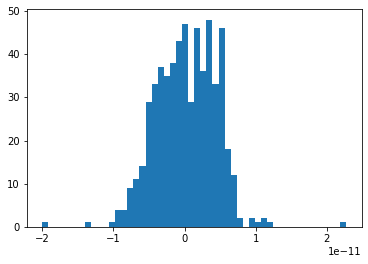

In [89]:
residuo = y_train_cover_label - df_predictions
plt.hist(residuo, bins=50);

In [90]:
pd.Series(residuo).describe()

count    5.840000e+02
mean     2.086854e-13
std      4.278819e-12
min     -2.000888e-11
25%     -2.728484e-12
50%      0.000000e+00
75%      3.637979e-12
max      2.273737e-11
Name: registered, dtype: float64

#### Regressor Random Forest

In [91]:
forest_reg = RandomForestRegressor(n_estimators=10, random_state=RANDOM_SEED)

X_train, X_test, y_train, y_test = train_test_split(
    df_prepared,
    y_train_cover_label,
    test_size=0.2,
    random_state=RANDOM_SEED,
)

forest_reg.fit(X_train, y_train)

y_pred = forest_reg.predict(X_test)
forest_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('Regressão random forest: RMSE = {:.2f}'.format(forest_rmse))

Regressão random forest: RMSE = 216.32


#### Árvore de Decisão

In [92]:
tree_reg = DecisionTreeRegressor(random_state=RANDOM_SEED)
tree_reg.fit(X_train, y_train)

y_pred = tree_reg.predict(X_test)
tree_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('Regressão árvore de decisão: RMSE = {:.2f}'.format(tree_rmse))

Regressão árvore de decisão: RMSE = 222.82


### Avaliação do melhor Regressor

In [93]:
# Regressão Linear

lin_scores = cross_val_score(
    lin_reg,  # modelo
    df_prepared,  # X_train
    y_train_cover_label,  # y_train
    scoring='neg_mean_squared_error',  # metrica de interesse
    cv=10,  # Quantas partições eu quero
    n_jobs=-1,  # Use todos os cores da maquina!
)
lin_rmse_scores = np.sqrt(-lin_scores)


def display_scores(scores):
    print('Scores:', scores.round(decimals=2))
    print('Mean:', scores.mean())
    print('Standard deviation:', scores.std())


display_scores(lin_rmse_scores)

C:\Users\VICTOR HABIB\Anaconda3\lib\site-packages\sklearn\externals\joblib\numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.


Scores: [20.15 20.06 10.35 32.35 27.46 14.09 19.3  17.59 19.45 11.46]
Mean: 19.226441672547814
Standard deviation: 6.402154289411195


In [94]:
# Random Forest

forest_scores = cross_val_score(
    forest_reg,
    df_prepared,
    y_train_cover_label,
    scoring='neg_mean_squared_error',
    cv=10,
    n_jobs=-1,
)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

C:\Users\VICTOR HABIB\Anaconda3\lib\site-packages\sklearn\externals\joblib\numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.


Scores: [205.38 270.6  145.07 180.7  153.43 219.7  127.57 139.9  127.65 185.87]
Mean: 175.587689100509
Standard deviation: 43.92344753961763


In [95]:
# Decision Tree

tree_scores = cross_val_score(
    tree_reg,
    df_prepared,
    y_train_cover_label,
    scoring='neg_mean_squared_error',
    cv=10,
    n_jobs=-1,
)
tree_rmse_scores = np.sqrt(-tree_scores)
display_scores(tree_rmse_scores)

Scores: [277.81 325.36 203.19 287.08 207.61 319.92 186.54 203.82 199.92 186.87]
Mean: 239.81222200519824
Standard deviation: 53.215770166964134


C:\Users\VICTOR HABIB\Anaconda3\lib\site-packages\sklearn\externals\joblib\numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.


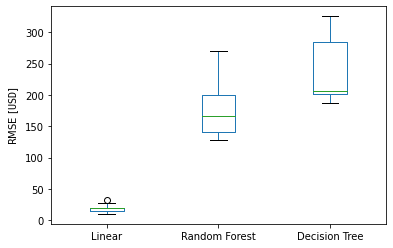

In [96]:
pd.DataFrame({
    'Linear': lin_rmse_scores,
    'Random Forest': forest_rmse_scores,
    'Decision Tree': tree_rmse_scores,
}).plot.box(
    xlabel='Regressor',
    ylabel=r'RMSE $[\mathtt{USD}]$',
    figsize=(6, 4),
);

Assim como o outro modelo, a regressão linear é o melhor método de regressão para prever o número de bicicletas alugadas por dia em Washington por usuários que são registrados, já que apresentou o menor erro médio quadrático (RMSE).

# Modelo 3. (contagem de alugueis para casuals, por dia)

### 1) Separar a variável dependente das variáveis independentes

In [97]:
# Variáveis independentes: dataset original menos a coluna de valores dependentes.
X_train_cover = train_set.drop(columns=['casual'])
y_train_cover_label = train_set['casual'] 

### 2) Separar também as variáveis Numéricas e Categóricas

In [98]:
# Dataframe das Variáveis Numéricas
# Retirar as Colunas das Variáveis Categóricas
df_num = X_train_cover.drop(['dteday', 'season', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit'], axis=1) 
df_num.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
instant,584.0,366.272260,212.603690,1.000000,181.500000,371.500000,547.250000,731.000000
yr,584.0,2011.510274,0.500323,2011.000000,2011.000000,2012.000000,2012.000000,2012.000000
temp,584.0,0.494907,0.183500,0.059130,0.336458,0.510417,0.653541,0.861667
atemp,584.0,0.474020,0.163641,0.079070,0.337628,0.495881,0.607975,0.840896
hum,584.0,0.630534,0.142604,0.187917,0.520000,0.634167,0.731562,0.972500
windspeed,584.0,0.191568,0.077830,0.022392,0.134798,0.182837,0.235242,0.507463
registered,584.0,3646.015411,1563.563060,20.000000,2499.000000,3674.000000,4747.000000,6946.000000
cnt,584.0,4494.219178,1940.836228,22.000000,3128.250000,4551.000000,5922.500000,8714.000000


In [99]:
# Dataframe das Variáveis Categóricas
df_cat = X_train_cover[['dteday', 'season', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit']]

print(type(df_cat))
print(df_cat.head())

<class 'pandas.core.frame.DataFrame'>
         dteday  season mnth holiday   weekday workingday weathersit
460  2012-04-05  Spring  Apr      No  Thursday        Yes       Good
142  2011-05-23  Spring  Mai      No    Monday        Yes   Moderate
202  2011-07-22  Summer  Jul      No    Friday        Yes       Good
404  2012-02-09  Winter  Feb      No  Thursday        Yes       Good
716  2012-12-17    Fall  Dec      No    Monday        Yes   Moderate


### 3) Normalização dos Dados

In [100]:
# Pipeline para as Variáveis Numéricas

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

meu_imputer = SimpleImputer(strategy='median') #Valores Faltantes Substituídos pela Mediana
meu_scaler = StandardScaler()

num_pipeline = Pipeline([
    ('imputer', meu_imputer),
    ('std_scaler', meu_scaler),
])

df_num_tr = num_pipeline.fit_transform(df_num)
df_num_tr

array([[ 0.44594215,  0.97965889, -0.32674754, ...,  0.35956364,
         1.03633331,  1.01217373],
       [-1.05108084, -1.02076346,  0.74592808, ...,  0.54362099,
        -0.1331534 , -0.1135634 ],
       [-0.76862367, -1.02076346,  1.92768372, ..., -0.75186603,
        -0.52554276, -0.57097469],
       ...,
       [-0.41555221, -1.02076346,  0.23685891, ..., -0.18412118,
         0.3975004 ,  0.1710939 ],
       [-0.51911984, -1.02076346,  0.85046469, ..., -0.63993735,
         0.2662772 ,  0.13860584],
       [-0.21312457, -1.02076346, -0.83581125, ...,  1.46332907,
        -0.46857269, -0.74321298]])

In [101]:
# Cria o codificador para Variável Categórica

from sklearn.preprocessing import OneHotEncoder

meu_one_hot_encoder = OneHotEncoder(sparse=False)

cat_pipeline = Pipeline([
    ('cat_encoder', meu_one_hot_encoder),
])

df_cat_tr = cat_pipeline.fit_transform(df_cat)
df_cat_tr

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [102]:
# Pipeline para as Variáveis Categóricas e Numéricas

from sklearn.compose import ColumnTransformer

num_attribs = list(df_num)
cat_attribs = ['dteday', 'season', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit']

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', cat_pipeline, cat_attribs),
])

df_prepared = full_pipeline.fit_transform(X_train_cover)
df_prepared[:3]

array([[ 0.44594215,  0.97965889, -0.32674754, ...,  0.        ,
         1.        ,  0.        ],
       [-1.05108084, -1.02076346,  0.74592808, ...,  0.        ,
         0.        ,  1.        ],
       [-0.76862367, -1.02076346,  1.92768372, ...,  0.        ,
         1.        ,  0.        ]])

### 4) Modelos Preditivos de Regressões

#### Regressão Linear

In [103]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(df_prepared, y_train_cover_label)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [104]:
# Seleciona 5 pontos do conjunto de treinamento.
some_data = X_train_cover.iloc[:5]
some_labels = y_train_cover_label.iloc[:5]

In [105]:
some_data

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,registered,cnt
460,461,2012-04-05,Spring,2012,Apr,No,Thursday,Yes,Good,0.435000,0.431163,0.374167,0.219529,5265,6457
142,143,2011-05-23,Spring,2011,Mai,No,Monday,Yes,Moderate,0.631667,0.590296,0.810000,0.233842,3438,4274
202,203,2011-07-22,Summer,2011,Jul,No,Friday,Yes,Good,0.848333,0.840896,0.580417,0.133100,2825,3387
404,405,2012-02-09,Winter,2012,Feb,No,Thursday,Yes,Good,0.265000,0.261988,0.562083,0.194037,3667,3830
716,717,2012-12-17,Fall,2012,Dec,No,Monday,Yes,Moderate,0.393333,0.401500,0.907083,0.098258,4373,4585


In [106]:
some_labels

460    1192
142     836
202     562
404     163
716     212
Name: casual, dtype: int64

In [107]:
# Prepara os dados
some_data_prepared = full_pipeline.transform(some_data)
some_data_prepared

array([[ 0.44594215,  0.97965889, -0.32674754, ...,  0.        ,
         1.        ,  0.        ],
       [-1.05108084, -1.02076346,  0.74592808, ...,  0.        ,
         0.        ,  1.        ],
       [-0.76862367, -1.02076346,  1.92768372, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.18231546,  0.97965889, -1.25397404, ...,  0.        ,
         1.        ,  0.        ],
       [ 1.65109273,  0.97965889, -0.55401075, ...,  0.        ,
         0.        ,  1.        ]])

In [108]:
# Para obter as previsões, basta chamar o método predict()
predicted_labels = lin_reg.predict(some_data_prepared)
print('Predição: {}'.format(predicted_labels.round(decimals=2)))

# Compare com os valores originais:
print('Original: {}'.format(some_labels.values.round(decimals=2)))

Predição: [1192.  836.  562.  163.  212.]
Original: [1192  836  562  163  212]


In [109]:
from sklearn.metrics import mean_squared_error

df_predictions = lin_reg.predict(df_prepared)
lin_mse = mean_squared_error(y_train_cover_label, df_predictions)
lin_rmse = np.sqrt(lin_mse)
print('Regressão linear: RMSE = {:.2f}'.format(lin_rmse))

Regressão linear: RMSE = 0.00


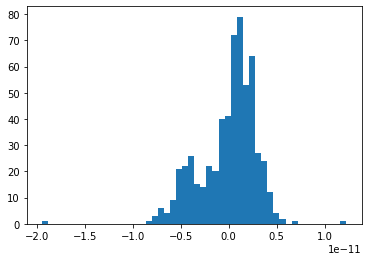

In [110]:
residuo = y_train_cover_label - df_predictions
plt.hist(residuo, bins=50);

In [111]:
pd.Series(residuo).describe()

count    5.840000e+02
mean    -3.445646e-14
std      2.930643e-12
min     -1.944045e-11
25%     -1.591616e-12
50%      6.252776e-13
75%      1.932676e-12
max      1.227818e-11
Name: casual, dtype: float64

#### Regressor Random Forest

In [112]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=10, random_state=RANDOM_SEED)

X_train, X_test, y_train, y_test = train_test_split(
    df_prepared,
    y_train_cover_label,
    test_size=0.2,
    random_state=RANDOM_SEED,
)

forest_reg.fit(X_train, y_train)

y_pred = forest_reg.predict(X_test)
forest_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('Regressão random forest: RMSE = {:.2f}'.format(forest_rmse))

Regressão random forest: RMSE = 269.85


#### Árvore de Decisão

In [113]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=RANDOM_SEED)
tree_reg.fit(X_train, y_train)

y_pred = tree_reg.predict(X_test)
tree_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('Regressão árvore de decisão: RMSE = {:.2f}'.format(tree_rmse))

Regressão árvore de decisão: RMSE = 312.95


### Avaliação do melhor Regressor

In [114]:
# Regressão Linear

from sklearn.model_selection import cross_val_score

lin_scores = cross_val_score(
    lin_reg,  # modelo
    df_prepared,  # X_train
    y_train_cover_label,  # y_train
    scoring='neg_mean_squared_error',  # metrica de interesse
    cv=10,  # Quantas partições eu quero
    n_jobs=-1,  # Use todos os cores da maquina!
)
lin_rmse_scores = np.sqrt(-lin_scores)


def display_scores(scores):
    print('Scores:', scores.round(decimals=2))
    print('Mean:', scores.mean())
    print('Standard deviation:', scores.std())


display_scores(lin_rmse_scores)

C:\Users\VICTOR HABIB\Anaconda3\lib\site-packages\sklearn\externals\joblib\numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.


Scores: [90.14 42.72 23.89 36.05 37.   53.76 27.11 33.53 93.46 30.27]
Mean: 46.791819232326276
Standard deviation: 23.863309349045057


In [115]:
# Random Forest

forest_scores = cross_val_score(
    forest_reg,
    df_prepared,
    y_train_cover_label,
    scoring='neg_mean_squared_error',
    cv=10,
    n_jobs=-1,
)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

C:\Users\VICTOR HABIB\Anaconda3\lib\site-packages\sklearn\externals\joblib\numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.


Scores: [306.93 230.51 165.16 175.31 174.96 251.64 153.47 171.06 170.7  162.25]
Mean: 196.20013151676503
Standard deviation: 47.56395946173192


In [116]:
# Decision Tree

tree_scores = cross_val_score(
    tree_reg,
    df_prepared,
    y_train_cover_label,
    scoring='neg_mean_squared_error',
    cv=10,
    n_jobs=-1,
)
tree_rmse_scores = np.sqrt(-tree_scores)
display_scores(tree_rmse_scores)

Scores: [318.04 271.87 206.93 192.39 225.2  270.64 217.28 228.95 206.72 295.93]
Mean: 243.39418609889822
Standard deviation: 40.47592682702642


C:\Users\VICTOR HABIB\Anaconda3\lib\site-packages\sklearn\externals\joblib\numpy_pickle.py:104: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.


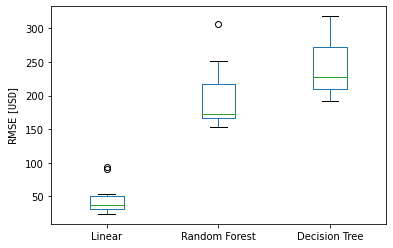

In [117]:
pd.DataFrame({
    'Linear': lin_rmse_scores,
    'Random Forest': forest_rmse_scores,
    'Decision Tree': tree_rmse_scores,
}).plot.box(
    xlabel='Regressor',
    ylabel=r'RMSE $[\mathtt{USD}]$',
    figsize=(6, 4),
);

Assim como os outros modelos, a regressão linear é o melhor método de regressão para prever o número de bicicletas alugadas por dia em Washington por usuários que são casuais, já que apresentou o menor erro médio quadrático (RMSE).

# Conclusão

Os 3 modelos criados apresentaram conclusões semelhantes, com destaque para o desempenho da regressão linear que apresentou erro 0 em todos os casos. Essa performance, à primeira vista, é perfeita, já que os modelos implementados preveem com exatidão os valores diários de alugúeis de bicicletas. Entretanto, tendo em vista os conhececimentos adquiridos nas aulas de Machine Learning, esses são típicos casos de overfitting. Mas o que exatamente significa um modelo preditivo apresentar características de overfitting?

Um modelo com overfitting têm uma complexidade alta a ponto de reduzir consideravelmente o erro de previsão com os dados de treino, mas ao mesmo tempo não é tão generalizável a ponto de apresentar um bom resultado ao aplicá-lo nos dados de teste. Nesse caso estamos optando por estimar um modelo com viés baixo e variância alta. Ou seja, no conjunto de treino, o modelo teria um erro de previsão baixo, mas quando avaliamos o modelo em um novo conjunto de dados (dados de teste), o erro aumenta significativamente, e por isso dizemos que sua variância é alta. Em termos mais simplórios, modelos com características de overfitting conseguem replicar o que foi feito no treino de maneira impecável, porém, qualquer mudança nos dados não se pode contar com ele (ele replica, não aprende).

Observando o conjunto de dados, acredita-se que a principal causa desse efeito é a escassez dos dados. O dataset apresenta menos de 1.000 amostras, um valor considerado baixo pela quantidade de variáveis que explicam tal estudo. Dessa forma, seria válido coletar amostras de outros anos para que a análise se torne mais completa e confiável.